This notebook accompanies Bezu & Bartholomaus (2024). It can be used to recreate the analysis and figures presented therein.

# Paths to required directories

Modify as needed

In [1]:
autoterm_path = '/data/stor/basic_data/spatial_data/greenland/terminus_positions/autoterm/Termini/Termini'
#^path to where AutoTerm terminus traces are stored. Files to be downloaded by the user
felikson_path = '/data/stor/basic_data/spatial_data/greenland/flowlines/felikson_shapefiles'
#^path to felikson flowline dataset. Files to be downloaded by the user
fahrner_path = '/data/stor/basic_data/spatial_data/greenland/flowlines/fahrner_shapefiles'
#^path to fahrner centerline dataset. Files to be downloaded by the user
itslive_felikson_path = '/data/stor/proj/terminus_shapefiles/itslive/felikson'
#^path to saved ITS_LIVE velocities at felikson terminus positions. Files can be created by the user or downloaded
itslive_fahrner_path = '/data/stor/proj/terminus_shapefiles/itslive/fahrner'
#^path to saved ITS_LIVE velocities at fahrner terminus positions. Files can be created by the user or downloaded
saved_arrays_path = '/data/stor/proj/terminus_shapefiles/calving_analysis'
#^path to saved arrays for Figure 2 creation. Files can be created by the user or downloaded
saved_figures_path = '/data/stor/proj/terminus_shapefiles/figures'

# Imports

In [2]:
import datetime
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
import pyproj
from scipy.signal import savgol_filter
import seaborn as sb
from shapely.geometry import LineString, Point
register_matplotlib_converters() #this somehow helps plotting datetime objects ¯\_(ツ)_/¯

# Select glacier ID and start date

In [3]:
autoterm_ID = '001' #glacier ID
start_date = '2014-01-01' if autoterm_ID == '090' else '2018-01-01'
end_date = '2022-01-01' #end date
flowline_author = 'fahrner' if autoterm_ID == '090' else 'felikson' #better quality, but may not reach terminus
# flowline_author = 'fahrner' #unreliable for glaciers with multiple branches, but extend further

start_date = pd.to_datetime(start_date) #convert start_date to datetime format
end_date = pd.to_datetime(end_date) #convert end_date to datetime format

In [4]:
#If adding more glaciers, you'll need to figure out which autoterm ids correspond to which fahrner or felikson ids

if autoterm_ID == '001':                               #Rink (RNK)
    fahrner_ID = 'GGN0347'
    felikson_ID, fl = '0015', '04'
elif autoterm_ID == '002':                             #Umiammakku (UMI)
    fahrner_ID = 'GGN0348'
    felikson_ID, fl = '0016', '04'
elif autoterm_ID == '005':                             #Upernavik (UPN)
    felikson_ID, fl = '0019', '05'
    fahrner_ID = 'XXXX' #bad
elif autoterm_ID == '090': #note: start 2014           #Ryder (RYD)
    fahrner_ID = 'GGN0697' 
    felikson_ID = '0103' #don't use
elif autoterm_ID == '021':                             #Alison (ALI)
    felikson_ID, fl = 'b034', '08'
    fahrner_ID = 'GGN0531'
elif autoterm_ID == '032':                             #Sverdrup (SVD)
    felikson_ID, fl = 'b045', '07'
    fahrner_ID = 'GGN0546'
elif autoterm_ID == '039':                             #Kong Oscar (KGO)
    fahrner_ID = 'GGN0553' #do not use
    felikson_ID, fl = '0050', '05' 
elif autoterm_ID == '152':                             #Kangerlussuaq (KGR)
    felikson_ID, fl = 'b173', '03'
    fahrner_ID = 'GGN0218'
elif autoterm_ID == '181':                             #Helheim (HEL)
    fahrner_ID = 'GGN0163'
    felikson_ID, fl = 'a199', '05'
elif autoterm_ID == '278':                             #Jakobshavn (JKH)
    felikson_ID, fl = '0001', '05'
    fahrner_ID = 'no fahrner id for this glacier'
elif autoterm_ID == '280':                             #Eqip (EQP)
    felikson_ID, fl = '0003', '03'
    fahrner_ID = 'GGN250'
elif autoterm_ID == '281':                             #KAN
    fahrner_ID = 'GGN0253'
    felikson_ID, fl = '0004', '05'
elif autoterm_ID == '282':                             #KUJ
    fahrner_ID = 'GGN0256'
    felikson_ID, fl = '0005', '04'
elif autoterm_ID == '283':                             #AVA
    fahrner_ID = 'GGN_0265'
    felikson_ID, fl = 'a006', '05'
elif autoterm_ID == '284':                             #Store (STR)
    felikson_ID, fl = '0007', '03'
    fahrner_ID = 'GGN0279'
elif autoterm_ID == '285':                             #LIL
    felikson_ID, fl = '0008', '05'
    fahrner_ID = 'GGNXXXX'
elif autoterm_ID == '286':                             #LIK
    felikson_ID, fl = '0009', '05'
    fahrner_ID = 'GGNXXXX'

# Grab terminus shapefiles

In [5]:
os.chdir(autoterm_path)

term_files = glob.glob('*.shp') #warning: these shapefiles aren't sorted right 
IDs = [int(term_files[i][3:-4])-1 for i in range(len(term_files))] #grab the glacier ID from each file name
term_files = [term_files[IDs.index(i)] for i in range(len(term_files))] #and sort files in order of glacier ID
term_shp = gpd.read_file(term_files[int(autoterm_ID)-1]) #this is the collection of traces with selected ID

termini, all_dates = [], []
for i in range(len(term_shp)):
    date = pd.to_datetime(term_shp['Date'][i])
    if date >= start_date and date <= end_date:
        termini.append(term_shp['geometry'][i]) #append only the traces within our date range
        all_dates.append(date)

start_date = np.min(all_dates) #adjust start_date to be the date of the first trace 
if end_date >= pd.Timestamp('2022-01-01'):
    end_date = np.max(all_dates) #adjust end_date to be the date of the last trace, if not already
end_index = np.max(np.where(np.array(all_dates) <= end_date))

In [6]:
print('Mean error:', np.mean([float(term_shp['Error'][i]) for i in range(len(term_shp))]), 'meters')

Mean error: 22.281787682106483 meters


# Grab flowline or centerline

In [7]:
if flowline_author == 'felikson':
    os.chdir(felikson_path)
elif flowline_author == 'fahrner':
    os.chdir(fahrner_path)
centerline_files = sorted(glob.glob('*.shp'))

for file in centerline_files:
    
    if fahrner_ID in file and flowline_author == 'fahrner':
        centerline = gpd.read_file(file)['geometry'][0]

    elif felikson_ID in file and flowline_author == 'felikson':
        centerline = gpd.read_file(file)
        index = np.where(centerline['flowline'] == fl)[0][0]
        centerline = centerline['geometry'][index]
        
        #felikson files need to be reprojected to WGS84
        
        wgs84, polar = pyproj.CRS.from_epsg(4326), pyproj.CRS.from_epsg(3413) 
        transformer = pyproj.Transformer.from_crs(polar, wgs84, always_xy = True) #(lon, lat), not (lat, lon)
        X, Y = centerline.xy[0], centerline.xy[1]
        lon, lat = transformer.transform(X, Y)
        centerline = LineString(zip(lon, lat))        
        break
        

if flowline_author == 'felikson': #need to extend slightly to reach the terminus
        dx = centerline.xy[0][0] - centerline.xy[0][1] #dx of final line segment in flowline multiline
        dy = centerline.xy[1][0] - centerline.xy[1][1] #dy of final line segment
        if dx == 0 or dy == 0: #if either is zero:
            dx = centerline.xy[0][0] - centerline.xy[0][2] #dx of final two line segments
            dy = centerline.xy[1][0] - centerline.xy[1][2] #dy of final two line segments
        x_new = centerline.xy[0][0] + 50*dx #new, extended x coordinate
        y_new = centerline.xy[1][0] + 50*dy #new, extended y coordinate
        xs = ([x_new] + list(centerline.xy[0])) 
        xs.reverse() #by default, felikson flowlines begin downstream and end upstream
        ys = ([y_new] + list(centerline.xy[1]))
        ys.reverse() #by reversing, advances are positive and retreats are negative

        centerline = LineString(zip(xs, ys)) #write the modified flowline as a linestring

## Plot terminus traces alongside flowline 

(-51.811324500000005, -51.5380132)

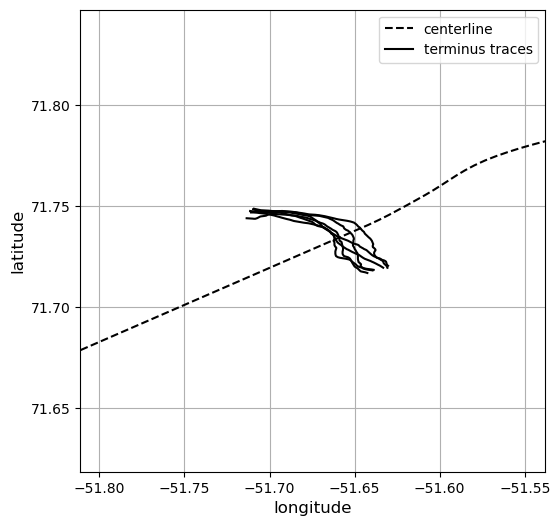

In [8]:
plt.figure(figsize=(6, 6))
plt.plot(centerline.xy[0], centerline.xy[1], color='k', linestyle='dashed', label='centerline')
plt.plot(termini[0].xy[0], termini[0].xy[1], color='k', label='terminus traces')
for i in np.arange(100, len(termini), 100):
    plt.plot(termini[i].xy[0], termini[i].xy[1], color='k')
plt.legend()
plt.grid()
plt.ylabel('latitude', fontsize=12)
plt.xlabel('longitude', fontsize=12)
buffer = 0.1
#plt.scatter(x_new, y_new)
plt.ylim(np.min(termini[-1].xy[1]) - buffer, np.max(termini[-1].xy[1]) + buffer)
plt.xlim(np.min(termini[-1].xy[0]) - buffer, np.max(termini[-1].xy[0]) + buffer)


# Generate terminus position timeseries

In [9]:
term_loc_latlon = [] #these will be in lat/lon by default
dates = [] #dates corresponding to terminus locations
failed_traces = 0
for i in range(len(termini)):
    try:
        intersect = Point(termini[i].intersection(centerline)) #fails if no intersect, or multiple intersects
        term_loc_latlon.append([intersect.x, intersect.y])
        dates.append(all_dates[i])
    except:
        failed_traces += 1

#transform into polar stereographic to easily convert advance/retreat to km 
wgs84, polar = pyproj.CRS.from_epsg(4326), pyproj.CRS.from_epsg(3413) 
transformer = pyproj.Transformer.from_crs(wgs84, polar, always_xy = True) #(lon, lat) instead of (lat, lon)

lon, lat = centerline.xy[0], centerline.xy[1]
x_coords, y_coords = transformer.transform(lon, lat)
centerline_polar = LineString(zip(x_coords, y_coords)) #flowline coords in polar stereographic

term_loc_polar = [] #terminus location timeseries in polar stereographic
for point in term_loc_latlon:
    lon, lat = point[0], point[1]
    x_coords, y_coords = transformer.transform(lon, lat)
    term_loc_polar.append(Point([x_coords, y_coords]))

terminus_positions = [] #1D terminus position array (i.e., projected onto flowline)
for point in term_loc_polar:
    terminus_positions.append(centerline_polar.project(point))
terminus_positions = np.array(terminus_positions) - terminus_positions[0] #calibrate to initial location

print('failed traces:', failed_traces)

failed traces: 1


/opt/anaconda/envs/spatialenv23a/lib/python3.10/site-packages/shapely/geometry/point.py:257: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if isinstance(ob[0], tuple):
/opt/anaconda/envs/spatialenv23a/lib/python3.10/site-packages/shapely/geometry/point.py:261: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  n = len(coords)
/opt/anaconda/envs/spatialenv23a/lib/python3.10/site-packages/shapely/geometry/point.py:262: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  dx = c_double(coords[0])


# Get ITS_LIVE velocity data 

Velocity data can be obtained from ITS_LIVE by following the steps below. For our study glaciers, we provide own own previously-downloaded ITS_LIVE data, which can be used if preferred. 

To create new ITS_LIVE timeseries, copy the following output to the clipboard:

In [10]:
print([[float(term_loc_latlon[i][0]), float(term_loc_latlon[i][1])] for i in np.arange(0, len(term_loc_latlon), 100)])

[[-51.65881416583062, 71.73455400356227], [-51.65905491582539, 71.7344658218094], [-51.66204745241995, 71.73336971743483], [-51.65504200958073, 71.73593566652157], [-51.64588892434043, 71.73928825268241], [-51.6472258061915, 71.73879858045989]]


Then go to the ITS_LIVE widget generate velocity timeseries for all points. Download the resulting velocity timeseries (typically a few excel files) to the directory ```itslive_felikson_path/autoterm_ID``` or ```itslive_felikson_path/autoterm_ID```. For example, UMI's autoterm ID is 002, so velocities for UMI along felikson terminus positions should be saved under ```itslive_felikson_path/002```. 

# Import the downloaded velocity data

In [11]:
if flowline_author == 'felikson':
    os.chdir(itslive_felikson_path+'/{}/'.format(autoterm_ID))
elif flowline_author == 'fahrner':
    os.chdir(itslive_fahrner_path+'/{}/'.format(autoterm_ID))

itslive_files = sorted(glob.glob('*.csv'))
velocities = []
velocity_error = []
velocity_timestamps = []
for file in itslive_files:
    data = pd.read_csv(file)
    temp_vel = data['v [m/yr]']
    temp_error = data['v_error [m/yr]']
    temp_dat = data['mid_date']
    for i in range(len(temp_dat)):
        timestamp = pd.Timestamp(temp_dat[i])
        if timestamp >= start_date and timestamp <= end_date:
            velocities.append(temp_vel[i])
            velocity_error.append(temp_error[i])
            velocity_timestamps.append(timestamp)

velocities = np.array(velocities)
velocity_error = np.array(velocity_error)
velocities[velocities > 2*np.median(velocities)] = np.median(velocities) #replace too-large vals

#interpolate positions and velocities to a common step size
t_pos = np.array([(dates[i] - start_date).total_seconds() for i in range(len(dates))])
#^dates of terminus position timeseries, in seconds since start date
t_vel = np.array([(velocity_timestamps[i] - start_date).total_seconds() for i in range(len(velocity_timestamps))])
#^dates of velocity timeseries, in seconds since start date, NOT SORTED CORRECTLY 
t_step = np.arange(0, np.max(t_pos), 60*60*24) 
#^date range as regularly-spaced time steps of one day 

zipped_pairs = zip(t_vel, velocities) #still need to sort the velocity timestep series
velocities = np.array([vel for _, vel in sorted(zipped_pairs)])
t_vel = sorted(t_vel)

zipped_pairs = zip(t_vel, velocity_error)
velocity_error = np.array([err for _, err in sorted(zipped_pairs)])

velocities = np.interp(t_step, t_vel, velocities) #interpolate to daily velocity
velocity_error = np.interp(t_step, t_vel, velocity_error)
position_interp = np.interp(t_step, t_pos, terminus_positions) #interpolate to daily terminus position



#And smooth the velocities over 15-day window
#Does not change much quantitatively, but makes plots look nicer
smoothed = savgol_filter(velocities, 15, 1)
smoothed = smoothed/(60*60*24*365) #put into m/s
cum_vel = np.zeros(np.shape(smoothed))
for i in range(1, len(smoothed)):
    cum_vel[i] = cum_vel[i-1] + smoothed[i]*(t_step[i] - t_step[i-1])
cumsum_interp = np.copy(cum_vel) #time-integrated velocity 

retreat = position_interp - cumsum_interp #Equation 1
total_retreat = np.abs(retreat[-1]) 
print('net retreat over timeseries:', total_retreat, 'm')

net retreat over timeseries: 16586.700035218026 m


In [12]:
print('mean velocity error:', np.mean(velocity_error)/np.mean(velocities)*100, 'percent')

mean velocity error: 1.5647786582860364 percent


# Identify calving events

In [13]:
series = LineString(zip(t_step, retreat))
calv_size = []
calv_date_begin = []
calv_date_end = []
calv_dt = []
net_retreat = 0

index = []
for i in np.arange(0, np.min(retreat), -1):
    straight_line = LineString(([0, i], [np.max(t_step), i]))
    try:
        pt = Point(straight_line.intersection(series)) 
        index_1 = np.max(np.where(t_pos < pt.x))
        index_2 = np.min(np.where(t_pos > pt.x))
        index_11 = np.where(t_step == t_pos[index_1])[0]
        index_22 = np.where(t_step == t_pos[index_2])[0]
        step = np.min([net_retreat, retreat[index_11]]) - retreat[index_22]
        step = float(step)
        time_step = t_step[index_22] - t_step[index_11]

        if t_step[index_11] not in calv_date_begin:
            calv_size.append(step)
            calv_date_begin.append(int(t_step[index_11]))
            calv_date_end.append(int(t_step[index_22]))            
            index.append(index_11)
            calv_dt.append(int(time_step))
            net_retreat -= step
            i = net_retreat


    except:
        continue
calv_size, calv_dt = np.array(calv_size), np.array(calv_dt)
calendar_date = [start_date + datetime.timedelta(0, t_step[i]) for i in range(len(t_step))]
calv_cal_date = [start_date + datetime.timedelta(0, calv_date_begin[i]) for i in range(len(calv_date_begin))]
calv_cal_date_end = [start_date + datetime.timedelta(0, calv_date_end[i]) for i in range(len(calv_date_end))]


/opt/anaconda/envs/spatialenv23a/lib/python3.10/site-packages/shapely/geometry/point.py:257: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if isinstance(ob[0], tuple):
/opt/anaconda/envs/spatialenv23a/lib/python3.10/site-packages/shapely/geometry/point.py:261: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  n = len(coords)
/opt/anaconda/envs/spatialenv23a/lib/python3.10/site-packages/shapely/geometry/point.py:262: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  dx = c_double(coords[0])
/opt/anaconda/envs/spatialenv23a/li

# Create Figure 1

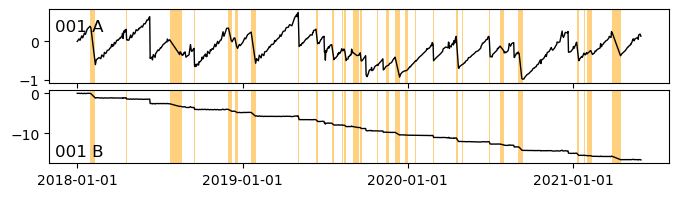

In [14]:
os.chdir(saved_figures_path)
if autoterm_ID == '090':
    panel_labels = ['A', 'B']
elif autoterm_ID == '002':
    panel_labels = ['E', 'F']
elif autoterm_ID == '181':
    panel_labels = ['C', 'D']
else:
    panel_labels = [f'{autoterm_ID} A', f'{autoterm_ID} B']
if autoterm_ID in ['090', '002', '181']:
    fig, axs = plt.subplots(2, sharex=True, sharey = False, figsize=(16, 3))
else:
    fig, axs = plt.subplots(2, sharex=True, sharey = False, figsize=(8, 2))
    

plt.subplots_adjust(hspace = 0.05)

if autoterm_ID in ['152', '181', '278', '001']:
    color_code, alpha = 'orange', 0.5
elif autoterm_ID in ['090']:
    color_code, alpha = 'red', 0.3
elif autoterm_ID in ['032', '005', '039', '021']:
    color_code, alpha = 'green', 0.3
elif autoterm_ID in ['002', '280', '281', '283', '285', '286']:
    color_code, alpha = 'blue', 0.2
elif autoterm_ID in ['282', '284']:
    color_code, alpha = 'purple', 0.3

Δ = datetime.timedelta(hours = 0)
for i in range(0, len(calv_cal_date)):
    if (calv_cal_date_end[i] - calv_cal_date[i]).days < 28:
        axs[0].axvspan(calv_cal_date[i] + Δ, calv_cal_date_end[i] - Δ, edgecolor = 'none', facecolor=color_code, alpha = alpha, label='step retreats')
        axs[1].axvspan(calv_cal_date[i] + Δ, calv_cal_date_end[i] - Δ, edgecolor = 'none', facecolor=color_code, alpha = alpha)
            
        

axs[0].plot(calendar_date, position_interp/1000, color='k', linewidth=1)
axs[1].plot(calendar_date, retreat/1000, color='k', linewidth=1, zorder=10)

if autoterm_ID == '090':
    axs[1].plot([calendar_date[0], np.max(calendar_date)], [0, 0], color='k', linestyle=(0, (1, 2)), linewidth=1, label='line 1')
    axs[1].plot([calendar_date[0], np.max(calendar_date)], [-2, -2], color='k', linestyle=(0, (1, 4)), linewidth=1, label='line 2')
    axs[1].plot([calendar_date[0], np.max(calendar_date)], [-4, -4], color='k', linestyle = (0, (1, 8)), linewidth=1, label='line 3')
    axs[1].legend(fontsize=12, loc = 'upper right') 
    axs[0].legend(loc = 'upper right', fontsize=12)

###########################
###########################
###########################
###########################



    
# axs[0].set_ylabel('$L$ (km)', fontsize=16)
# axs[1].set_xlabel('date', fontsize=16)
# axs[1].set_ylabel('$\sum c_i$ (km)', fontsize=16)
fig.align_ylabels(axs[:])
if autoterm_ID not in ['090', '002', '181']:
    axs[1].set_xticks([pd.to_datetime('2018-01-01'), pd.to_datetime('2019-01-01'), pd.to_datetime('2020-01-01'), pd.to_datetime('2021-01-01')], fontsize = 12)
    plt.subplots_adjust(hspace = 0.1)
    axs[0].text(0.01, 0.7, panel_labels[0], transform=axs[0].transAxes, fontsize=12)
    axs[1].text(0.01, 0.1, panel_labels[1], transform=axs[1].transAxes, fontsize=12)
else:
    axs[0].text(0.01, 0.8, panel_labels[0], transform=axs[0].transAxes, fontsize=12)
    axs[1].text(0.01, 0.8, panel_labels[1], transform=axs[1].transAxes, fontsize=12)

if autoterm_ID in ['278', '032', '021', '280', '283', '286', '284']:  
    axs[0].yaxis.tick_right()
    axs[1].yaxis.tick_right()
    
plt.savefig(f'{autoterm_ID}_Figure_1')


# Save arrays 

Or, for our study glaciers, use the provided arrays if preferred. 

In [15]:
os.chdir(saved_arrays_path)
np.save('{}_calving.npy'.format(autoterm_ID), calv_size, allow_pickle=True)
np.save('{}_dt.npy'.format(autoterm_ID), calv_dt, allow_pickle=True)
np.save('{}_retreat.npy'.format(autoterm_ID), retreat, allow_pickle=True)
np.save('{}_t_step.npy'.format(autoterm_ID), t_step, allow_pickle=True)
np.save(f'{autoterm_ID}_date.npy', calv_cal_date_end, allow_pickle = True)

# Create Figure 2

## Read saved arrays

In [16]:
os.chdir(saved_arrays_path)
files = sorted(glob.glob('*.npy'))
calving = []
retreat = []
t_step = []
dt = []
ids = []
calving_date = []

sorted_ids = ['090', '152', '181', '278', '001', '032', '005', '021', '039', '280', '281', '002', '283', '285',
             '286', '282', '284']
names = ['RYD', 'KGR', 'HEL', 'JKH', 'RNK', 'SVD', 'UPR', 'ALI', 'KGO', 'EQP', 'KAN', 'UMI', 'AVA', 'LIL', 'LIK',
        'KUJ', 'STR']

##Or use full names for more presentation-friendly figures

full_names = ['Ryder', 'Kangerlussuaq', 'Helheim', 'Jakobshavn', 'Rink', 'Sverdrup', 'Upernavik', 'Alison',
            'Kong Oscar', 'Eqip', 'Kangilleq', 'Umiammakku', 'Avannarleq', 'Lille ', 'Sermilik', 'Kujalleq', 'Store']

for glac in sorted_ids:
    for i in range(len(files)):
        ident = files[i][:3]
        if ident == glac:
            if 'calving' in files[i]:
                calving.append(np.load(files[i], allow_pickle=True))
                ids.append(files[i][:3])
            elif 'dt' in files[i]:
                dt.append(np.load(files[i], allow_pickle=True)/(60*60*24))
            elif 'retreat' in files[i]:
                retreat.append(-np.load(files[i], allow_pickle=True))
            elif 't_step' in files[i]:
                t_step.append(np.load(files[i], allow_pickle=True))
            elif 'date' in files[i]:
                calving_date.append(np.load(files[i], allow_pickle = True))


In [17]:
color_code = ['red', 'orange', 'orange', 'orange', 'orange', 'green', 'green', 'green', 'green',
              'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'purple', 'purple']

## Exclude unreliable step retreats  

In [18]:
t_max = 28 #will not consider any retreats identified between terminus traces more than 4 weeks apart

real_events = []
real_dates = []
calving_month = []
for i in range(len(calving)):
    temp_1, temp_2, temp_3 = [], [], []
    for j in range(len(calving[i])):
        if dt[i][j] <= t_max:
            temp_1.append(calving[i][j])
            temp_2.append(calving_date[i][j])
            temp_3.append(int(str(calving_date[i][j])[5:7]))
    real_events.append(np.array(temp_1))
    real_dates.append(np.array(temp_2))
    calving_month.append(np.array(temp_3))
real_events = np.array(real_events, dtype='object')
real_dates = np.array(real_dates, dtype = 'object')
calving_month = np.array(calving_month, dtype = 'object')

## Plot a reduced, powerpoint-friendly version of Figure 2

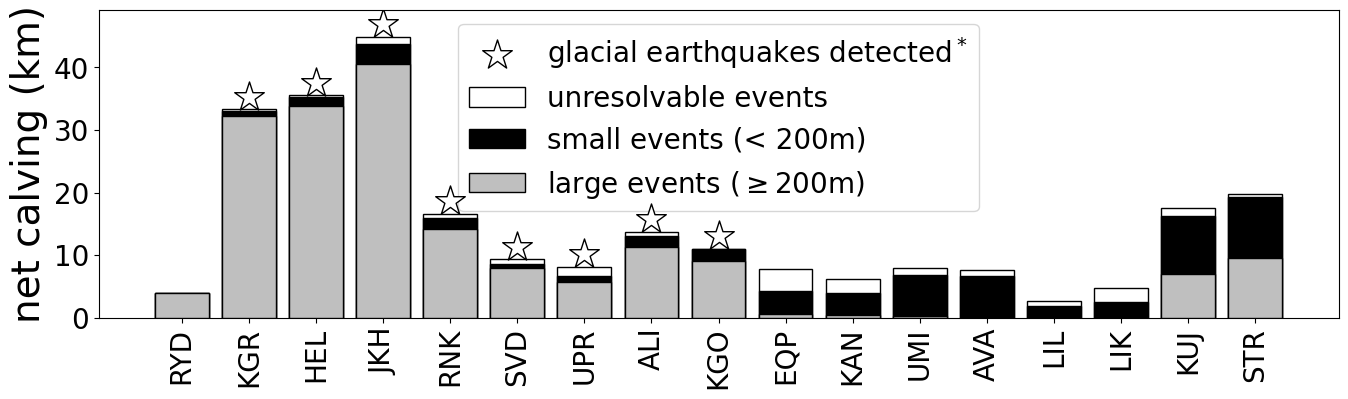

In [19]:
fig, ax = plt.subplots(figsize=(16, 4))
min_size = 200 #events larger than this will be 'large'
width = 0.8
ax.bar(range(len(retreat)), [retreat[i][-1]/1000 for i in range(len(retreat))], width = width, edgecolor='k', facecolor='none', zorder=1, label='unresolvable events')
ax.bar(range(len(retreat)), [np.sum(real_events[i])/1000 for i in range(len(calving))], width = width, edgecolor= 'k', facecolor='k', label='small events (< {}m)'.format(min_size), zorder = 2)
ax.bar(range(len(retreat)), [np.sum(real_events[i][real_events[i] > min_size])/1000 for i in range(len(calving))], width = width, edgecolor='k', facecolor='0.75', label='large events ($\geq${}m)'.format(min_size), zorder = 3)
plt.scatter(1, retreat[1][-1]/1000 + 2, marker = '*', s=500, edgecolor='k', facecolor='w', zorder = 10, label = 'glacial earthquakes detected$^*$')
for i in range(2, 9):
    plt.scatter(i, retreat[i][-1]/1000 + 2, marker = '*', s=500, edgecolor='k', facecolor='w', zorder=10)

plt.xticks(range(len(names)), names, fontsize=20,rotation=90) 
plt.yticks(fontsize=20)
plt.ylabel('net calving (km)', fontsize=28)
plt.legend(fontsize=20)
plt.show()

# Plot full Figure 2

/tmp/ipykernel_35797/420403709.py:5: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[0].get_shared_x_axes().join(axs[0], axs[2])
/tmp/ipykernel_35797/420403709.py:6: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1].get_shared_x_axes().join(axs[1], axs[2])


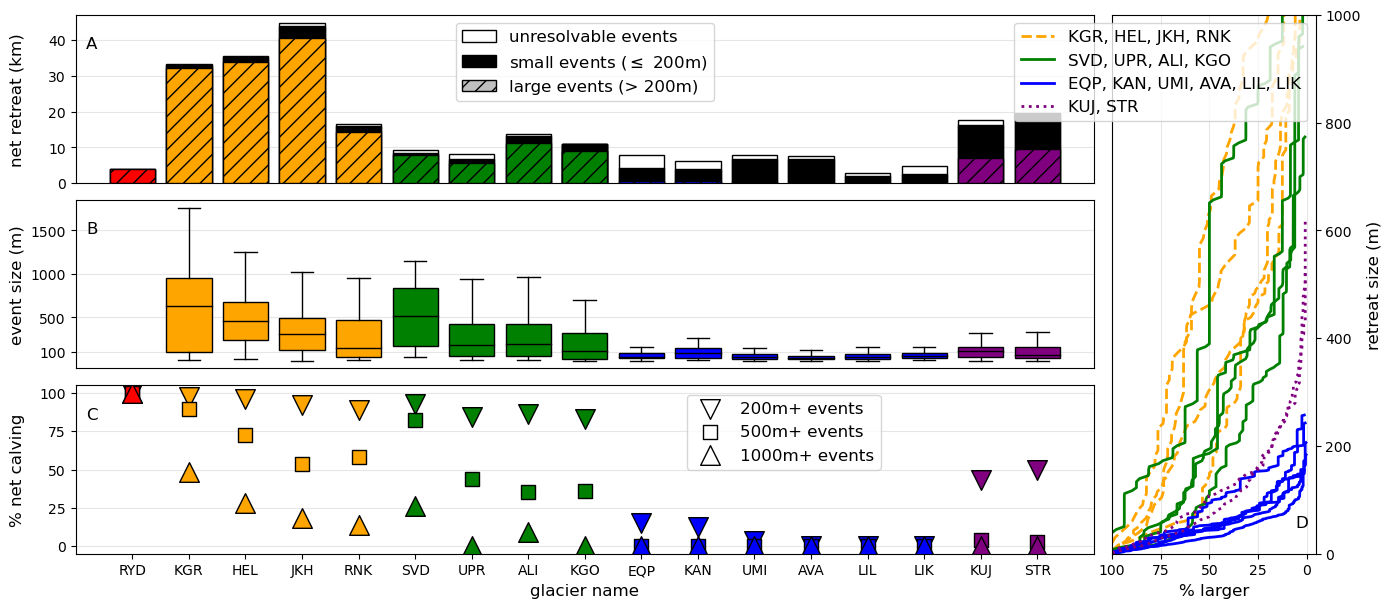

In [20]:
os.chdir(saved_figures_path)
fig = plt.figure(figsize=(16, 7))
axs = fig.subplot_mosaic([[0, 3], [1, 3], [2, 3]], gridspec_kw = {'width_ratios':[5, 1]})

axs[0].get_shared_x_axes().join(axs[0], axs[2])
axs[1].get_shared_x_axes().join(axs[1], axs[2])
fig.align_ylabels([axs[0], axs[1], axs[2]])
fig.align_xlabels([axs[2], axs[3]])

plt.subplots_adjust(hspace = 0.1)
plt.subplots_adjust(wspace = 0.03)
plt.xlim(-1, len(ids))



############################
# First subplot: bar graph #
############################

min_size = 200 #events larger than this will be 'large'
width = 0.8
axs[0].bar(i, retreat[i][-1]/1000, width = width, edgecolor= 'k', facecolor='none', zorder=1, label = 'unresolvable events')
axs[0].bar(i, np.sum(real_events[i])/1000, width = width, edgecolor= 'k', facecolor='k', label='small events ($\leq$ {}m)'.format(min_size), zorder = 2)
axs[0].bar(i, np.sum(real_events[i][real_events[i] > min_size])/1000, width = width, edgecolor='k', facecolor= '0.75', hatch = '//', label='large events (> {}m)'.format(min_size), zorder = 3)

for i in range(len(retreat)):
    axs[0].bar(i, retreat[i][-1]/1000, width = width, edgecolor= 'k', facecolor='none', zorder=1)
    axs[0].bar(i, np.sum(real_events[i])/1000, width = width, edgecolor= 'k', facecolor='k', zorder = 2)
    axs[0].bar(i, np.sum(real_events[i][real_events[i] > min_size])/1000, width = width, edgecolor='k', facecolor= color_code[i], hatch = '//', zorder = 3)

###########################
# Second subplot: boxplot #
###########################

for i in range(len(calving)):
    if len(calving[i]) >= 2:
        quartile_1, median, quartile_3 = np.percentile(real_events[i], [25, 50, 75]) 
        box_plot = axs[1].boxplot(sorted(real_events[i], reverse=True)[:], positions=[i], showfliers=False, patch_artist = True, widths=0.8)
        for median in box_plot['medians']:
            median.set_color('k')
        for patch, color in zip(box_plot['boxes'], color_code):
            patch.set_facecolor(color_code[i])

############################
# Third subplot: triangles #
############################

small = 200
med = 500
big = 1000 

i = 0 #plot first one seperately to assign labels for legend:
lower = np.sum(real_events[i][real_events[i] > small])/np.sum(real_events[i])*100
mid = np.sum(real_events[i][real_events[i] > med])/np.sum(real_events[i])*100
upper = np.sum(real_events[i][real_events[i] > big])/np.sum(real_events[i])*100
axs[2].scatter(i, lower, marker ='v', s = 200, edgecolor='k', facecolor='w', label='{}m+ events'.format(small))
axs[2].scatter(i, mid, marker='s', s=100, edgecolor='k', facecolor='w', label='{}m+ events'.format(med))
axs[2].scatter(i, upper, marker='^', s=200, edgecolor='k', facecolor='w', label='{}m+ events'.format(big))
axs[2].scatter(i, lower, marker ='v', s = 200, edgecolor='k', facecolor=color_code[i])
axs[2].scatter(i, mid, marker='s', s=100, edgecolor='k', facecolor=color_code[i])
axs[2].scatter(i, upper, marker='^', s=200, edgecolor='k', facecolor=color_code[i])

for i in range(1, len(ids)): #and plot the rest
    if len(calving[i]) >= 1:
        lower = np.sum(real_events[i][real_events[i] > small])/np.sum(real_events[i])*100
        mid = np.sum(real_events[i][real_events[i] > med])/np.sum(real_events[i])*100
        upper = np.sum(real_events[i][real_events[i] > big])/np.sum(real_events[i])*100
        axs[2].scatter(i, lower, marker ='v', s = 200, edgecolor='k', facecolor=color_code[i])
        axs[2].scatter(i, mid, marker='s', s=100, edgecolor='k', facecolor=color_code[i])
        axs[2].scatter(i, upper, marker='^', s=200, edgecolor='k', facecolor=color_code[i])
        
####################################
# Fourth plot: cumulative KDE plot #
####################################

smooth = 0.01
alpha = 0.1
min_val, max_val = 0, 1000

for i in range(len(ids)):
    if ids[i] in ['002', '280', '281', '283', '285', '286']:
        if ids[i] == '002':
            max_val = np.max(real_events[i])
            sb.kdeplot(ax = axs[3], y = real_events[i], bw_adjust = smooth, fill=False, color=color_code[i], linewidth = 2, clip = (min_val, max_val), cumulative=True, label='EQP, KAN, UMI, AVA, LIL, LIK')
        else:
            max_val = np.max(real_events[i])
            sb.kdeplot(ax = axs[3], y = real_events[i], bw_adjust = smooth, fill=False, color=color_code[i], linewidth = 2, clip = (min_val, max_val), cumulative=True)
    elif ids[i] in ['282', '284']:
        if ids[i] == '282':
            max_val = np.max(real_events[i])
            sb.kdeplot(ax = axs[3], y = real_events[i], bw_adjust = smooth, fill=False, color=color_code[i], linewidth = 2, linestyle ='dotted', clip = (min_val, max_val), cumulative=True, label='KUJ, STR')
        else:
            max_val = np.max(real_events[i])
            sb.kdeplot(ax = axs[3], y = real_events[i], bw_adjust = smooth, fill=False, color=color_code[i], linewidth = 2, linestyle ='dotted', clip = (min_val, max_val), cumulative=True)
    elif ids[i] in ['005', '021', '032', '039']:
        if ids[i] == '005':
            max_val = np.max(real_events[i])
            sb.kdeplot(ax = axs[3], y = real_events[i], bw_adjust = smooth, fill=False, color=color_code[i], linewidth = 2, clip = (min_val, max_val), cumulative=True, label = 'SVD, UPR, ALI, KGO')
        else:
            max_val = np.max(real_events[i])
            sb.kdeplot(ax = axs[3], y = real_events[i], bw_adjust = smooth, fill=False, color=color_code[i], linewidth = 2,clip = (min_val, max_val), cumulative=True)

    elif ids[i] in ['152', '181', '278', '001']:
        if ids[i] == '152':
            max_val = np.max(real_events[i])
            sb.kdeplot(ax = axs[3], y = real_events[i], bw_adjust = smooth, fill=False, color=color_code[i], linestyle ='dashed', linewidth = 2, clip = (min_val, max_val), cumulative=True, label='KGR, HEL, JKH, RNK')
        else:
            max_val = np.max(real_events[i])
            sb.kdeplot(ax = axs[3], y = real_events[i], bw_adjust = smooth, fill=False, color=color_code[i], linestyle ='dashed', linewidth = 2, clip = (min_val, max_val), cumulative=True)

###############
# Axis labels #
###############

axs[0].set_xticks([], [])
axs[0].set_ylabel('net retreat (km)', fontsize=12)
axs[0].legend(fontsize=12, loc = 'upper center')

axs[1].set_xticks([], [])
axs[1].set_yticks([100, 500, 1000, 1500])
axs[1].set_ylabel('event size (m)', fontsize=12)

axs[2].set_xticks(range(len(names)), names)         
axs[2].set_xlabel('glacier name', fontsize=12)
axs[2].set_yticks(np.arange(0, 101, 25))
axs[2].set_ylabel('% net calving', fontsize=12)   
axs[2].legend(fontsize=12, loc = (0.6, 0.5))

axs[3].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0], [100, 75, 50, 25, 0])
axs[3].set_xlabel('% larger', fontsize=12)
axs[3].yaxis.tick_right()
axs[3].set_ylim(0, 1000)
axs[3].set_ylabel('retreat size (m)', fontsize=12)
axs[3].yaxis.set_label_position('right')
axs[3].legend(fontsize=12, loc='upper right')

axs[0].text(0.01, 0.8, 'A', transform=axs[0].transAxes, fontsize=12)
axs[1].text(0.01, 0.8, 'B', transform=axs[1].transAxes, fontsize=12)
axs[2].text(0.01, 0.8, 'C', transform=axs[2].transAxes, fontsize=12)
axs[3].text(0.90, 0.05, 'D', transform=axs[3].transAxes, fontsize=12)

axs[0].set_axisbelow(True)
axs[0].grid(color='0.9', axis='y')
axs[1].set_axisbelow(True)
axs[1].grid(color='0.9', axis='y')
axs[2].set_axisbelow(True)
axs[2].grid(color='0.9', axis='y')
axs[3].set_axisbelow(True)
axs[3].grid(color='0.9', axis='x')

# plt.tight_layout()
plt.savefig('Figure_2')

# Generate stats for Results section

In [21]:
for i in range(len(calving)):
    print(names[i], ids[i], ':', retreat[i][-1]/1000, 'km retreat,', np.sum(real_events[i])/1000, 'km calving,', len(real_events[i]), 'events,', np.sum(real_events[i][real_events[i] > 200])/np.sum(real_events[i]), 'percent,')

RYD 090 : 4.018716735980781 km retreat, 4.010056325957535 km calving, 1 events, 1.0 percent,
KGR 152 : 33.33268227583994 km retreat, 33.01168741165262 km calving, 49 events, 0.9762260384487806 percent,
HEL 181 : 35.5248795913007 km retreat, 35.206869053624395 km calving, 68 events, 0.9613360083057427 percent,
JKH 278 : 44.85418980160955 km retreat, 43.805528179398905 km calving, 119 events, 0.9238812663700934 percent,
RNK 001 : 16.586700035218026 km retreat, 15.942310614108916 km calving, 56 events, 0.8917292429507776 percent,
SVD 032 : 9.374547130842512 km retreat, 8.516005661760294 km calving, 16 events, 0.9245467017852755 percent,
UPR 005 : 8.158383816486937 km retreat, 6.676307248823601 km calving, 24 events, 0.8451146983786015 percent,
ALI 021 : 13.738987576480625 km retreat, 13.126978917520738 km calving, 49 events, 0.8601531801320222 percent,
KGO 039 : 11.003630576103316 km retreat, 10.951057507956161 km calving, 58 events, 0.8320387863513385 percent,
EQP 280 : 7.859378795467748